## Running the Linear AA on the Beta Cells dataset

#### NO NEED TO RERUN ALL! Load the results in the .pth file

In [1]:
import torch
import numpy as np
import scanpy as sc
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import torch
import numpy as np
from torchvision import datasets, transforms
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt 
from src.methods.AALS import AALS 

In [2]:

# 1. Load Data
print("Loading single-cell dataset...")
# Load the dataset (assuming 'data/beta_cells_hfd.h5ad' is accessible)
adata = sc.read_h5ad('data/beta_cells_hfd.h5ad')

Loading single-cell dataset...


In [3]:
# 1. Standard Single-Cell Preprocessing (No Binarization)
# Convert to dense (if sparse) and apply log-transformation
X_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X.copy()
# Use scanpy's built-in log normalization for robustness
X_log_normalized = sc.pp.log1p(X_dense, copy=True)

### Running the Gayssian method on the cell data
- Used 4 as n_archetypes because that's what we used in the AANet implementation, for comparison.

In [4]:
# Convert to PyTorch tensor
X_tensor = torch.from_numpy(X_log_normalized).float()

# 2. Transpose and Convert to Double
# X_tensor is (Cells x Genes). Required shape is (Genes x Cells)
X = X_tensor.t().double() 

# Chose the same as the AANET implementation for consistency
n_archetypes = 4

# 3. Run the AALS Method (Gaussian)
C, S, L, EV = AALS(X, n_archetypes)

#### Save to avoid rerunning

In [ ]:
# Save the results for later visualization
torch.save({'C': C, 'S': S, 'L': L}, 'betacells_gaussian_aa_results.pth')

### Trying to visualize the results

In [ ]:
# Load the results for visualization
results = torch.load('betacells_gaussian_aa_results.pth')
C = results['C']
S = results['S']
L = results['L']


1. 🗺️ **What the UMAP Plot Shows** ($\mathbf{S}$ Matrix)

The UMAP plot visualizes the results of the $\mathbf{S}$ matrix (the coefficient matrix):
    - Cells (Points): The cells are arranged based on their gene expression similarity.
    - Archetype Assignment (Color): Each color represents the dominant archetype assignment for a cell, derived from the $\mathbf{S}$ matrix ($\text{Cell}_i$ is colored by the index of the highest coefficient in its column of $\mathbf{S}$).

Conclusion: The UMAP plot shows the clustering or grouping of your cells into the four archetypal populations.

/Users/joaomata/AANet_env_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


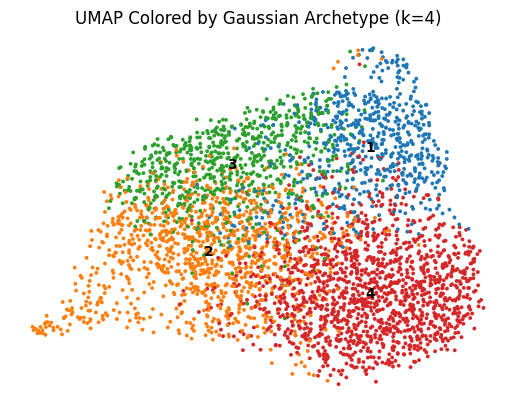

In [7]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch

# --- 1. Ensure UMAP is Calculated on the Continuous Data ---
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata) # Run PCA
# ADD THIS LINE: Calculate the k-nearest neighbors graph
sc.pp.neighbors(adata)
# Now UMAP can run successfully
sc.tl.umap(adata) # Run UMAP

# --- 2. Process S Matrix (Archetypal Assignment) ---

# S is expected to be a (n_archetypes x N_cells) tensor: (4, N_cells)
if isinstance(S, torch.Tensor):
    S_np = S.detach().cpu().numpy()
else:
    S_np = S.copy()

# Transpose S to be (N_cells x n_archetypes) so rows match the cells in adata.obs
S_cells = S_np.T

# Find the index (0, 1, 2, or 3) of the maximum coefficient for each cell.
# This index defines the cell's dominant archetype.
dominant_archetype_index = np.argmax(S_cells, axis=1)

# Add the assignment (plus 1 for labeling) back to the scanpy object
adata.obs['dominant_archetype'] = pd.Categorical(dominant_archetype_index + 1)

# --- 3. Plot the UMAP ---

sc.pl.umap(
    adata, 
    color='dominant_archetype', 
    title='UMAP Colored by Gaussian Archetype (k=4)',
    legend_loc='on data',
    frameon=False
)

Corrected C_np shape: (3887, 4)
DataFrame creation successful.


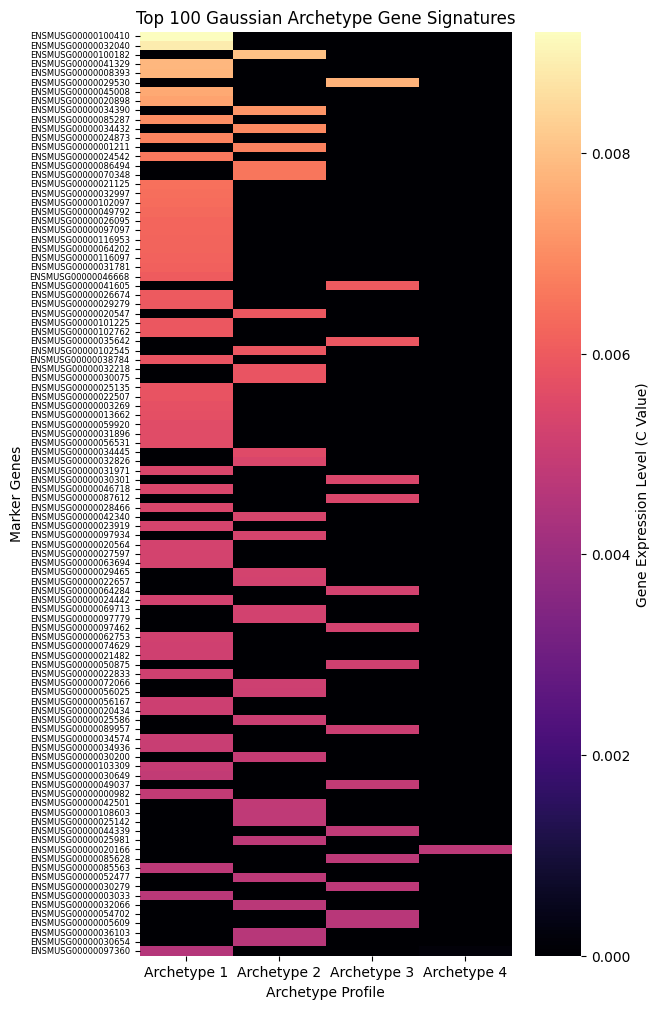

In [9]:
# --- 1. Correct Transposition and Gene Name Mismatch ---

# Check the input C matrix shape (4, 3887)
# We need (3887, 4) -> Transpose C_np
C_np = C_np.T

print(f"Corrected C_np shape: {C_np.shape}") # Should be (3887, 4)

# Get the gene names that correspond to the features used in the analysis.
# If you ran PCA on highly variable genes, those names are in adata.var_names
# filtered by the features actually used.
# Since C_np has 3887 rows, we must use 3887 gene names. 
# We'll assume the first 3887 genes in adata are the ones used. 
# You should verify this assumption based on your full data loading script.
gene_names = adata.var_names[:C_np.shape[0]].to_list() 

# 2. Re-create the DataFrame with Corrected Dimensions
C_df = pd.DataFrame(
    C_np, 
    index=gene_names, # Now correctly matched (3887 gene names)
    columns=[f'Archetype {i+1}' for i in range(C_np.shape[1])] # (4 Archetype columns)
)
print("DataFrame creation successful.")

# --- The rest of your visualization code continues here ---
# ... C_df['Max_Expr'] = C_df.max(axis=1) ...

# Find the maximum expression value across all 4 archetypes for each gene
C_df['Max_Expr'] = C_df.max(axis=1)

# Sort by Max_Expr and select the top 100 genes
C_top = C_df.sort_values(by='Max_Expr', ascending=False).head(100).drop(columns=['Max_Expr'])

# --- 3. Plot Heatmap ---

plt.figure(figsize=(6, 12))
sns.heatmap(
    C_top,
    cmap='magma', # High-contrast color map
    cbar_kws={'label': 'Gene Expression Level (C Value)'},
    yticklabels=True # Ensure gene names are labeled
)

plt.title('Top 100 Gaussian Archetype Gene Signatures')
plt.ylabel('Marker Genes')
plt.xlabel('Archetype Profile')
plt.yticks(rotation=0, fontsize=6)
plt.show()

In [12]:
import pandas as pd # Ensure pandas is imported

# Set the number of top genes you want to see
N_TOP_GENES = 5

print(f"--- Top {N_TOP_GENES} Genes Defining Each of the Four Archetypes ---")
print("-" * 55)

# Iterate through each column (Archetype) in the DataFrame
for col in C_df.columns:
    # Sort the current archetype column in descending order
    top_genes = C_df[col].sort_values(ascending=False).head(N_TOP_GENES)
    
    print(f"\n🔬 {col}:")
    # Print the gene name (index) and its contribution value
    for gene, contribution in top_genes.items():
        print(f"  {gene:<20} {contribution:.4f}")
    
print("-" * 55)

--- Top 5 Genes Defining Each of the Four Archetypes ---
-------------------------------------------------------

🔬 Archetype 1:
  ENSMUSG00000100410   0.0092
  ENSMUSG00000032040   0.0089
  ENSMUSG00000041329   0.0078
  ENSMUSG00000008393   0.0078
  ENSMUSG00000045008   0.0075

🔬 Archetype 2:
  ENSMUSG00000100182   0.0080
  ENSMUSG00000034390   0.0072
  ENSMUSG00000034432   0.0069
  ENSMUSG00000001211   0.0068
  ENSMUSG00000086494   0.0066

🔬 Archetype 3:
  ENSMUSG00000029530   0.0077
  ENSMUSG00000041605   0.0060
  ENSMUSG00000035642   0.0059
  ENSMUSG00000030301   0.0054
  ENSMUSG00000087612   0.0054

🔬 Archetype 4:
  ENSMUSG00000020166   0.0047
  ENSMUSG00000037326   0.0043
  ENSMUSG00000002985   0.0042
  ENSMUSG00000030766   0.0042
  ENSMUSG00000055172   0.0040

🔬 Max_Expr:
  ENSMUSG00000100410   0.0092
  ENSMUSG00000032040   0.0089
  ENSMUSG00000100182   0.0080
  ENSMUSG00000041329   0.0078
  ENSMUSG00000008393   0.0078
-------------------------------------------------------
